# Cours 8 - Clustering

Dans les cours précédents nous avons pu explorer les techniques de machine learning supervisé, aujourd'hui nous allons explorer les techniques de machine learning non-supervisé grâce au clustering. 
Le but du cours sera donc d'identifier un certain nombre de groupes sur des données non labélisées.

Sources:
* https://www.youtube.com/watch?v=mEGYznC6F9s 
* https://www.kaggle.com/code/prashant111/k-means-clustering-with-python/notebook
* https://www.youtube.com/watch?v=_UVHneBUBW0
* https://www.youtube.com/watch?v=FD4DeN81ODY
* https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

original_data = pd.read_csv('data.csv')


## Partie 1 - K-means Clustering

Tout d'abord explorons le fonctionnement du clustering avec l'algorithme K-means. 

**Exercice 1:** A partir de la documentation [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), décrivez avec vos mots les paramètres principaux de l'algorithme K-means.

**Exercice 2:** A partir du [dataset sur le cancer du sein](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data), entrainez un algorithme K-means en 2 dimensions sur les colonnes `smoothness-mean` et `area_worst`. Présentez un scatterplot montrant les clusters que l'agorithme à identifié ainsi que les centroides des clusters. Présentez également les paramètres utilisés pour entrainer le modèle. 

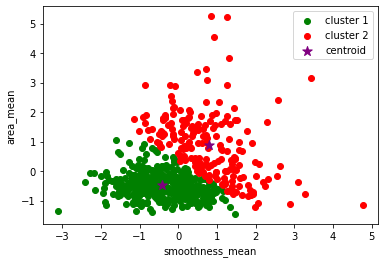

In [55]:
# area_mean
# smoothness_mean

data = original_data.get(['smoothness_mean', 'area_mean'])
# normalize the data
data = (data - data.mean()) / data.std()

# plt.scatter(data["smoothness_mean"], data["area_mean"])
km = KMeans(n_clusters=2)
y_predict = km.fit_predict(data)
data["cluster"] = y_predict


data1 = data[data.cluster==0]
data2 = data[data.cluster==1]

# place the centroids in a dataframe
centroids = data.groupby(["cluster"]).mean()

plt.scatter(data1.smoothness_mean, data1.area_mean, color='green', label='cluster 1', )
plt.scatter(data2.smoothness_mean, data2.area_mean, color='red', label='cluster 2')
plt.scatter(centroids.smoothness_mean, centroids.area_mean, color='purple', marker='*', label='centroid', s=100)
plt.xlabel('smoothness_mean')
plt.ylabel('area_mean')
plt.legend(
    ncol=1,
    fancybox=True,
)


## Partie 2 - Elbow Method
Dans cette partie nous allons explorer la elbow method qui nous permettera de choisir quel nombre de clusters semble optimal. 

**Exercice 3:** Creez un line plot nous montrant l'évolution de la distortion du modèles selon le nombre de clusters choisis. L'attribut du modèle `intertia_` sera surement utile. 
Quel semble le meilleur nombre de clusters pour nos données ?

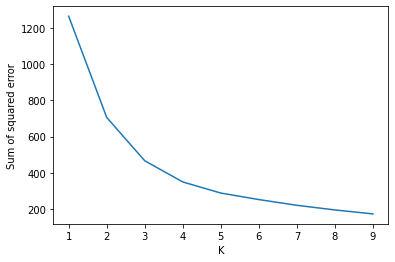

In [45]:
# elblow method
sse = []
k_rng = range(1, 10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sse.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)


**Exercice 4:** Réitérez l'exercice 2 avec le nombre de clusters optimal trouvez grâce à l'elbow method.

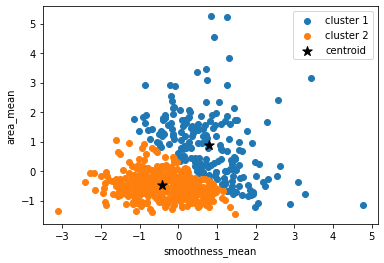

In [46]:
# iterate over the clusters
for i in range(2):
    # filter the data
    data1 = data[data.cluster==i]
    # plot the data
    plt.scatter(data1.smoothness_mean, data1.area_mean, label='cluster '+str(i+1))
# plot the centroids
plt.scatter(centroids.smoothness_mean, centroids.area_mean, color='black', marker='*', label='centroid', s=100)
plt.xlabel('smoothness_mean')
plt.ylabel('area_mean')
plt.legend()

## Partie 3 - Principal Component Analysis (PCA)

Comme nous sommes dans des cas les données ne sont pas labélisés nous avons très peu de moyen d'évaluer si nos clusters semblent pertinents à part la visualisations graphique de nos clusters. 
Or nous aimerions fortement pourvoir prendre en compte plus de données que seulement 2 colonnes pour créer nos clusters. 
Pour cela nous pouvons utiliser la PCA qui est une technique de réduction de dimensionalités.

**Exercice 5**: Appliquez une [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) à toutes les colonnes possibles de notre dataset puis affichez un scatterplot des PC1 et PC2.

In [77]:
from sklearn.preprocessing import StandardScaler
# data normalization and cleaning
pca_data = original_data.drop(['id'], axis=1)

# remove rows with missing values
pca_data.dropna()
# convert M and B to 1 and 0
pca_data.diagnosis = [1 if each == "M" else 0 for each in pca_data.diagnosis]

# normalize the data to have 0 mean and 1 standard deviation
pca_data_normalize = StandardScaler().fit_transform(pca_data)

In [88]:
# pca for all columns in the dataset and scatterplot the first two components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pcaTransformed = pca.fit_transform(pca_data_normalize)
pcaTransformed

principalDf = pd.DataFrame(data=pcaTransformed, columns = ['PC1', 'PC2'])
principalDf.head()

finalDf = pd.concat([principalDf, original_data[['diagnosis']]], axis = 1)
finalDf.head()

,PC1,PC2,diagnosis
0,9.225770,2.116196,M
1,2.655802,-3.784776,M
2,5.892492,-1.005579,M
3,7.135401,10.318716,M
4,4.129423,-1.905579,M


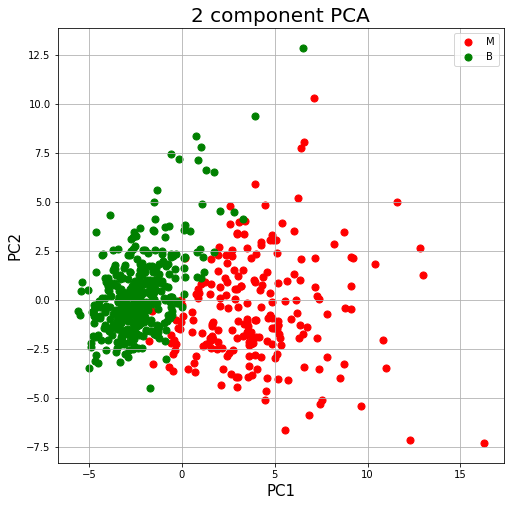

In [54]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
targets = ['M', 'B']
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'],
               finalDf.loc[indicesToKeep, 'PC2'], c=color, s=50)
ax.legend(targets)
ax.grid()


**Exercice 6**: Grâce à l'extrait de code suivant affichez un bar plot de l'influence de chaque colonne sur le PC1 puis sur le PC2.       
Quelles sont donc les 2 colonnes ayant le plus d'importance ? 

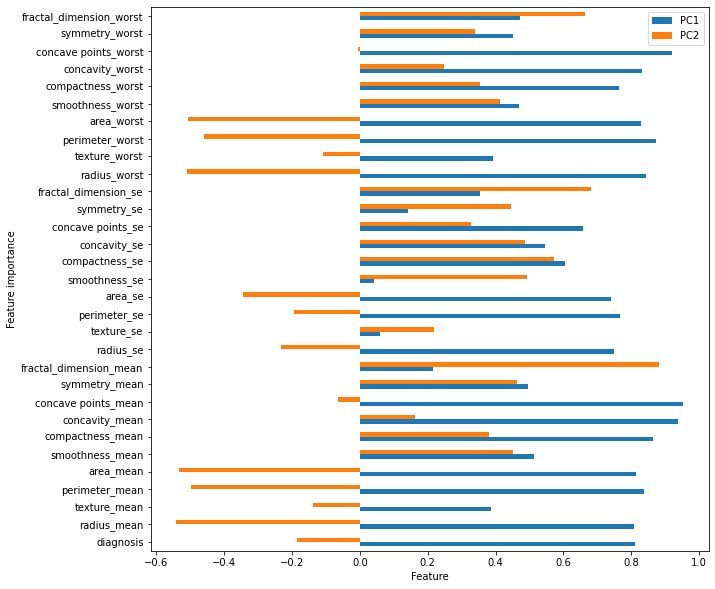

In [75]:

loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=['PC1', 'PC2'],
    index=pca_data.columns
)
loadings



# show bar plot of the loadings
fig, ax = plt.subplots(figsize=(10, 10))
# loadings.plot.bar(ax=ax)
loadings.plot.barh(ax=ax)
ax.set_ylabel('Feature importance')
ax.set_xlabel('Feature')
ax.legend(loc='upper right')


Avant de pouvoir entrainer un algorithme de K-means sur nos données isues de PCA nous voulons tout de même confirmer que nos pC1 et PC2 nous permettent d'exprimer la majoriter de la variance de notre dataset.
Pour cela nous pouvons creer un "scree plot". Un scree plot est un diagramme qui exprime la quantité de variance exprimée pour chaqune des composantes principales.

**Exercice 7:** Creez un scree plot de nos composantes principales. L'attribut `explained_variance_ratio_` de notre objet pca pourra être utile.         
Est-ce que se concentrer sur les 2 premières PC est suffisant ?

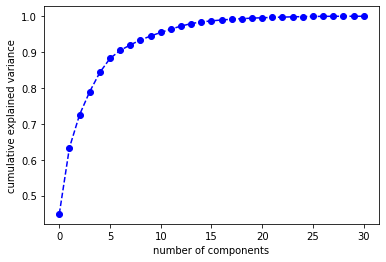

In [91]:
# scree plot of all principal components and their explained variance ratio
pca = PCA()
pca.fit(pca_data_normalize)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
# non pas suffisant pour expliquer 90% de la variance des données (on a besoin de 5 composantes principales)


**Exercice 8:** Appliquez une PCA en précisant le nombre de composantes principales voulues (`n_components`).     
Puis ensuite entrainez un algorithme K-means sur vos données issues de la PCA. 
Avez vous séléctionné le bon nombre de clusters grâce à l'elbow method ? 
Présentez un scatterplot montrant les clusters que l'agorithme à identifié ainsi que les centroides des clusters.    Présentez également les paramètres utilisés pour entrainer le modèle.    

In [90]:
# apply PCA with 5 components
pca = PCA(n_components=5)
pcaTransformed = pca.fit_transform(pca_data_normalize)

# show the explained variance ratio of each component



array([0.44896035, 0.18472104, 0.09183385, 0.06446333, 0.05351866])

## Partie 4 - Evaluation
Comme nous sommes dans un cas particulier ou nous avons des données labélisées à l'originie, nous pouvons évaluer la performance de nos clustering. 

**Exercice 9:** Comparez le scatter plot issu de l'exercice 2 vs. le scatterplot des donnés avec leur vrais labels.    
Que remarquez vous ?   
Vous pouvez également calculer l'accuracy, la confusion matrix et le F1 score du K-means issu de l'exercice 2 par rapport aux vrais labels.    
Quelles sont leur valeurs ? 

**Exercice 10:** Comparez le scatter plot issu de l'exercice 8 vs. le scatterplot des donnés avec leur vrais labels.    
Que remarquez vous ?   
Vous pouvez également calculer l'accuracy, la confusion matrix et le F1 score du K-means issu de l'exercice 8 par rapport aux vrais labels.    
Quelles sont leur valeurs ? 

**Exercice 11:** Pour conclure, quelle pipeline de clustering performe le mieux ? Le clustering de l'exercice 2 ou bien le clustering de l'exercice 9

## Bonus 

**Bonus 1:** Entrainez vos compétences algorithmiques en python et recodez l'algorithme K-means !

**Bonus 2:** Il existe bien d'autres algorithmes de clustering que l'algorithme K-means, testez ces algorithmes et trouvez le meilleur algorithme pour notre problème !        
Cet article devrait vous aider:
https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb